In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl
import math
import glob
import os

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]+['eval','cleaned','']))
from params_opt_maps import *

In [2]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'
path_tab=path_data+'tables/'

In [3]:
# Names
model_map={**pkl.load(open(path_names+'models.pkl','rb')),
           **pkl.load(open(path_names+'models_additional.pkl','rb'))}
param_map=pkl.load(open(path_names+'params.pkl','rb'))
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))
params_opt_gene_map=pkl.load(open(path_names+'params_opt_genes.pkl','rb'))
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))
cell_type_map=pkl.load(open(path_names+'cell_types.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))

## Top settings
Best performing parameter setting results

In [5]:
# Load metrics and embeddings
load_embed=True
metrics={}
if load_embed:
    embeds={}
args={}
for dataset,dataset_name in dataset_map.items():
    top_settings=pkl.load(open(f'{path_data}eval/{dataset}/integration_summary/top_settings.pkl','rb'))
    metrics[dataset_name]=[]
    if load_embed:
        embeds[dataset_name]={}
    args[dataset_name]={}
    path_integration=f'{path_data}eval/{dataset}/integration/'
    for model,model_setting in top_settings.items():
        model=model_map[model]
        for run in model_setting['runs']:
            args_run=pkl.load(open(path_integration+run+'/args.pkl','rb'))
            metrics_data=pd.Series(
                pkl.load(open(path_integration+run+'/scib_metrics.pkl','rb')),
                name=model)
            metrics_data['seed']=args_run.seed
            metrics[dataset_name].append(metrics_data)
            if run==model_setting['mid_run']:
                if load_embed:
                    embeds[dataset_name][model]=sc.read(path_integration+run+'/embed.h5ad')
                args[dataset_name][model]=args_run
    metrics[dataset_name]=pd.DataFrame(metrics[dataset_name])
    metrics[dataset_name]['model']=pd.Categorical(
        values=metrics[dataset_name].index,
        categories=[m for m in model_map.values() if m in metrics[dataset_name].index],
        ordered=True)
    metrics[dataset_name].rename(metric_map,axis=1,inplace=True)
    # Seed to str for plotting
    metrics[dataset_name]['seed']=metrics[dataset_name]['seed'].astype(str)

In [ ]:
# Add non-integrated embeds
if load_embed:
    dataset_embed_fns={
        'pancreas_conditions_MIA_HPAP2':'combined_orthologuesHVG_embed.h5ad',
        'retina_adult_organoid':'combined_HVG_embed.h5ad',
        'adipose_sc_sn_updated':'adiposeHsSAT_sc_sn_embed.h5ad',
    }
    for dataset,dataset_name in dataset_map.items():
        embeds[dataset_name][model_map['non-integrated']]=sc.read(
            f'{path_data}{dataset}/{dataset_embed_fns[dataset]}')

In [6]:
# Add scGEN example embeds to retina
if load_embed:
    dataset='retina_adult_organoid'
    dataset_name=dataset_map[dataset]
    example_runs=pkl.load(open(f'{path_data}eval/{dataset}/integration_summary/example_runs.pkl','rb'))
    path_integration=f'{path_data}eval/{dataset}/integration/'
    for model,run in example_runs.items():
        model=model_map[model]
        embeds[dataset_name][model]=sc.read(path_integration+run+'/embed.h5ad')

In [7]:
# Display loaded embeddings
if load_embed:
    for i,j in embeds.items():
        print('*** '+i)
        print(j.keys())

*** Mouse-Human
dict_keys(['cVAE', 'CYC', 'SATURN', 'SATURN-CT', 'GLUE', 'scVI', 'VAMP', 'VAMP+CYC', 'Non-integrated'])
*** Organoid-Tissue
dict_keys(['cVAE', 'CYC', 'GLUE', 'scVI', 'VAMP', 'VAMP+CYC', 'Non-integrated', 'scGEN - sample', 'scGEN - system'])
*** Cell-Nuclei
dict_keys(['cVAE', 'CYC', 'GLUE', 'scVI', 'VAMP', 'VAMP+CYC', 'Non-integrated'])


### Metric scores

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(x=x, y=y, **kws)
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of th

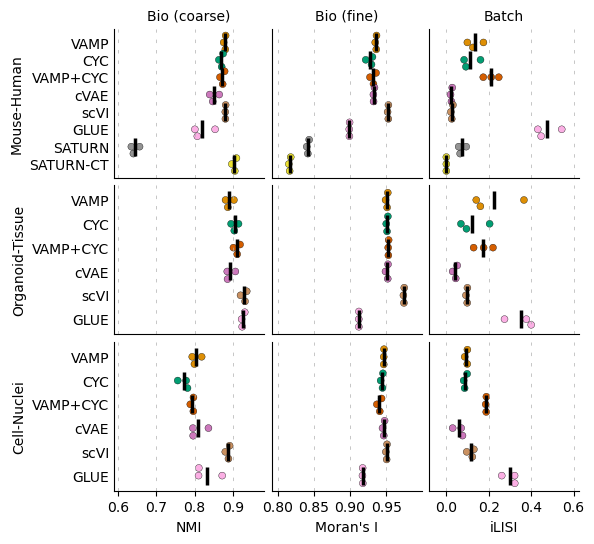

In [14]:
# Plot metric scores

# X range for metrics axes
xlims={}
for metric in metric_map.values():
    mins=[]
    maxs=[]
    for data in metrics.values():
        mins.append(data[metric].min())
        maxs.append(data[metric].max())
    x_min=min(mins)
    x_max=max(maxs)
    x_buffer=(x_max-x_min)*0.15
    x_min=x_min-x_buffer 
    x_max=x_max+x_buffer
    xlims[metric]=(x_min,x_max)

# Plots
n_rows=len(metrics)
n_cols=len(metric_map)
fig,axs=plt.subplots(n_rows,n_cols,figsize=(2*n_cols,len(metric_map)/1.5*n_rows),
                     sharey='row',sharex='col')
for row,(dataset_name,metrics_sub) in enumerate(metrics.items()):
    for col,metric in enumerate(metric_map.values()):
        ax=axs[row,col]
        means=metrics_sub.groupby('model')[metric].mean().reset_index()
        sb.swarmplot(y='model',x=metric,data=metrics_sub,ax=ax,
                     edgecolor='k',linewidth=0.25,
                     hue='model',palette=model_cmap, s=5, zorder=1)
        sb.scatterplot(y='model',x=metric,data=means,ax=ax,
                       edgecolor='k',linewidth=2.5,
                       color='k', s=150, marker='|', zorder=2)
        # Make pretty
        ax.set_xlim(xlims[metric][0],xlims[metric][1])
        ax.get_legend().remove()
        ax.tick_params(axis='y', which='major', length=0)
        ax.set(facecolor = (0,0,0,0))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if row!=(n_rows-1):
            ax.set_xlabel('')
            ax.tick_params(axis='x', which='major', length=0)
        else:
            ax.locator_params(axis='x', nbins=5)
        if row==0:
            ax.set_title(metric_meaning_map[metric_map_rev[metric]],fontsize=10)
        if col==0:
            ax.set_ylabel(dataset_name)
        else:
            ax.set_ylabel('')
        ax.grid(which='major', axis='x',linestyle=(0, (5, 10)),lw=0.5)
fig.set(facecolor = (0,0,0,0))
plt.subplots_adjust( wspace=0.05,hspace=0.05)

# Save
plt.savefig(path_fig+'performance-score_topsettings-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'performance-score_topsettings-swarm.png',
            dpi=300,bbox_inches='tight')

Significance of difference between pairs of models per metric and datatset. Pvalue adjustment is performed per metric and dataset across model pairs.

In [39]:
# Significance of model differences
pvals=[]
for dataset_name,metrics_sub in metrics.items():
    models = metrics_sub['model'].cat.categories
    n_models = len(models)
    for metric in metric_map.values():
        pvals_sub=[]
        for m1 in range(n_models-1):
            for m2 in range(m1+1,n_models):
                model1=models[m1]
                model2=models[m2]
                t,p=ttest_ind(
                    metrics_sub.loc[model1,metric], metrics_sub.loc[model2,metric], 
                    equal_var=False, alternative='two-sided')
                pvals_sub.append(dict(
                    dataset=dataset_name,metric=metric,p=p,t=t, 
                    model_cond=model1,model_ctrl=model2,
                    # This does not account if t is exactly 0, but this would be very unlikely
                    higher=model1 if t>0 else model2))
        pvals_sub=pd.DataFrame(pvals_sub)
        padj_method='fdr_tsbh'
        pvals_sub['padj_'+padj_method]=multipletests(pvals_sub['p'].values, method=padj_method)[1]
        pvals.append(pvals_sub)
pvals=pd.concat(pvals)
pvals.to_csv(path_tab+'performance-score_topsettings-pairwise_significance.tsv',sep='\t',index=None)

/tmp/ipykernel_28652/4073201360.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p=ttest_ind(


### UMAPs
UMAP of representative run from top setting

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data f

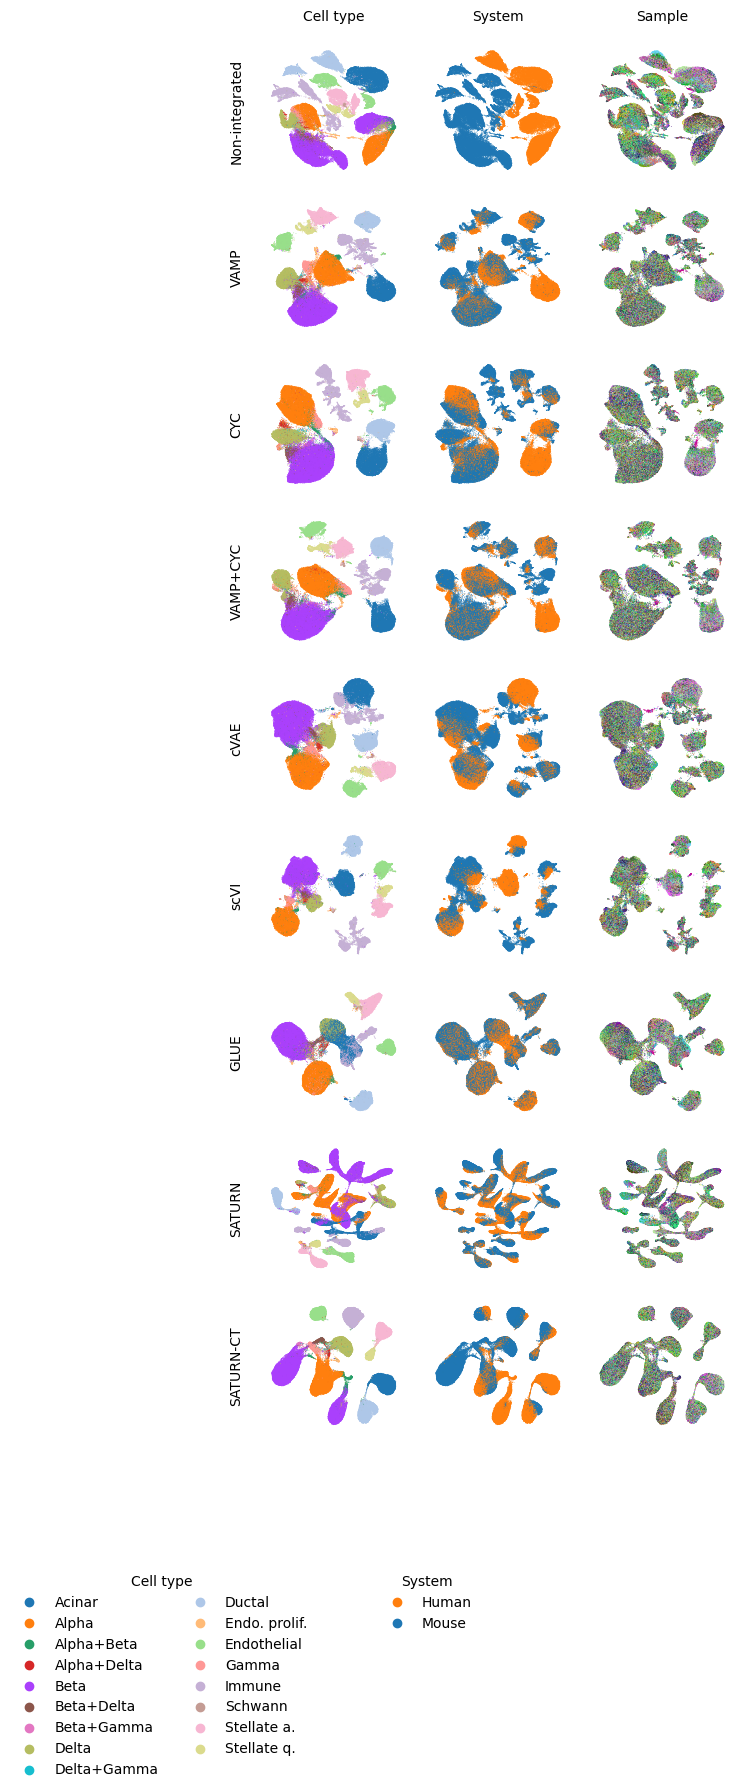

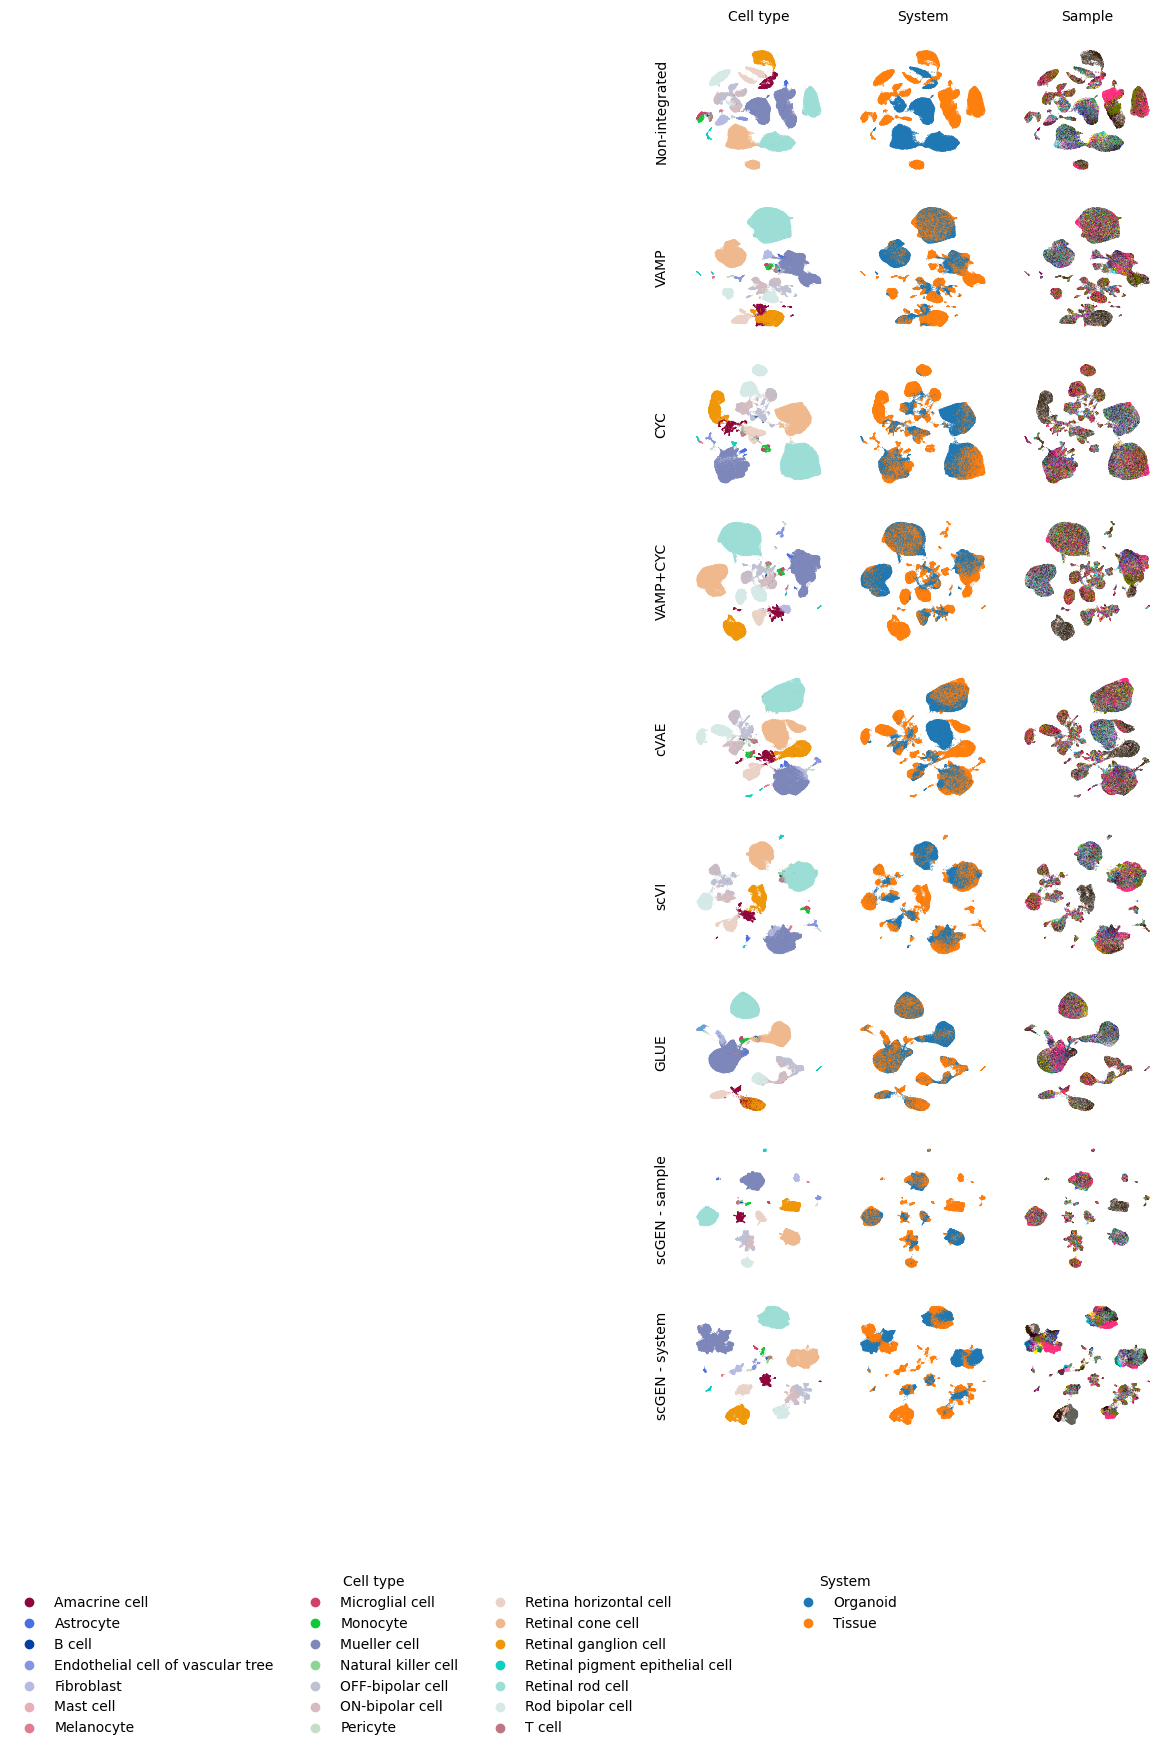

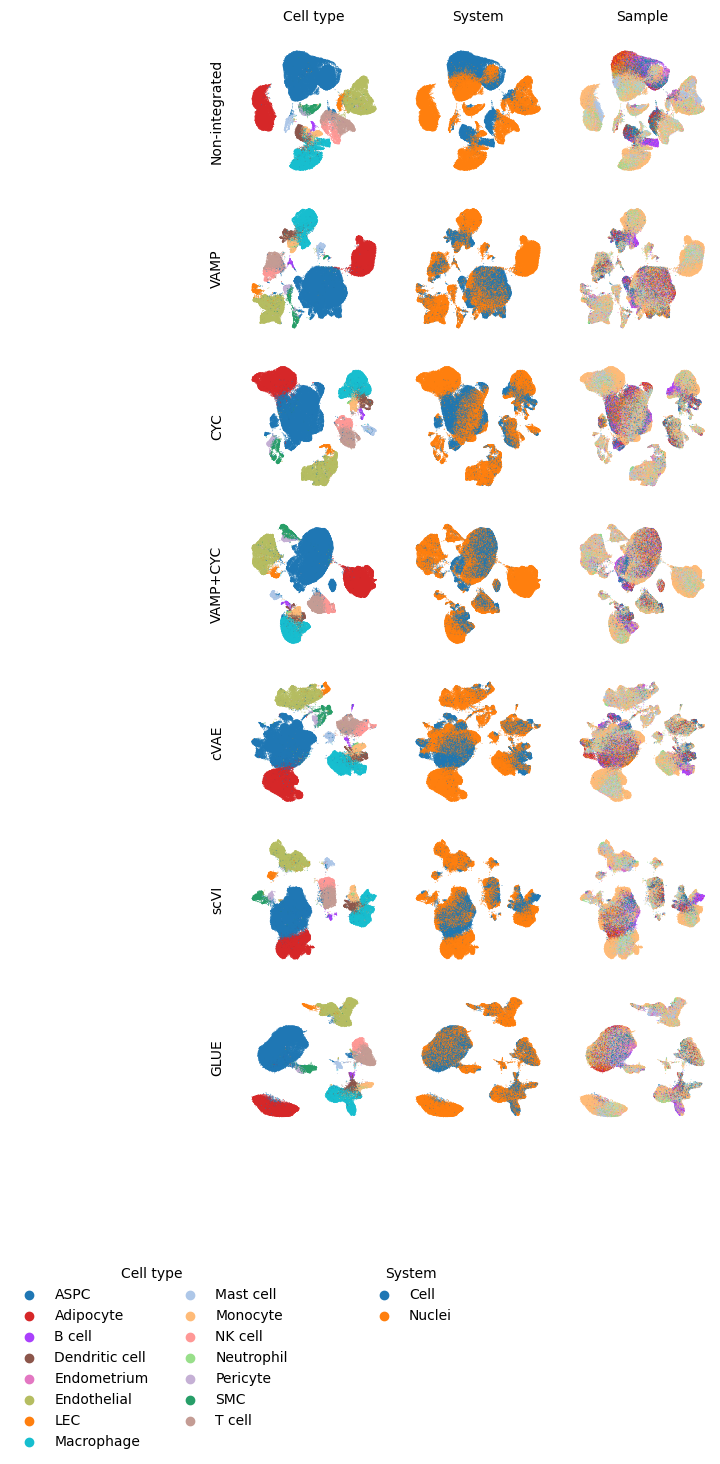

In [9]:
# UMAP plot per data setting 

# Column names of colored covariates
ct_col_name='Cell type'
sys_col_name='System'
sample_col_name='Sample'
for dataset,dataset_name in dataset_map.items():
    embeds_ds=embeds[dataset_name]
    ncols=3
    nrows=len(embeds_ds)
    fig,axs=plt.subplots(nrows,ncols,figsize=(2*ncols,2*nrows))
    # Args for ct, system, sample col names - same in all models
    args_sub=list(args[dataset_name].values())[0]
    # Plot every model
    for irow,model_name in enumerate([m for m in model_map.values() if m in embeds_ds]):
        embed=embeds_ds[model_name]
        for icol,(col_name,col) in enumerate(zip(
            [ct_col_name,sys_col_name,sample_col_name],
            [args_sub.group_key,args_sub.system_key,args_sub.batch_key])):

            # Set cmap and col val names
            cmap=obs_col_cmap[dataset_map_rev[dataset_name]][col]
            if col_name==sys_col_name:
                # Map system to str as done in integrated embeds but not in non-int
                embed.obs[col+'_parsed']=embed.obs[col].astype(str).map(system_map[dataset])
                cmap={system_map[dataset][k]:v for k,v in cmap.items()}
            elif col_name==ct_col_name:
                # Map system to str as done in integrated embeds but not in non-int
                embed.obs[col+'_parsed']=embed.obs[col].astype(str).map(cell_type_map[dataset])
                cmap={cell_type_map[dataset][k]:v for k,v in cmap.items()}
            else:
                embed.obs[col+'_parsed']=embed.obs[col]

            # Plot
            ax=axs[irow,icol]
            sc.pl.umap(embed,color=col+'_parsed',ax=ax,show=False,
                      palette=cmap, frameon=False,title='')

            # Make pretty
            if irow==0:
                ax.set_title(col_name+'\n',fontsize=10)

            if icol==0:
                ax.axis('on')
                ax.tick_params(
                        top='off', bottom='off', left='off', right='off', 
                        labelleft='on', labelbottom='off')
                ax.set_ylabel(model_name+'\n',rotation=90)
                ax.set_xlabel('')
                ax.set(frame_on=False)

            if irow!=(nrows-1) or col_name==sample_col_name:
                ax.get_legend().remove()
            else:
                ax.legend(bbox_to_anchor=(0.4,-1),frameon=False,title=col_name,
                          ncol=math.ceil(embed.obs[col].nunique()/10))

    fig.set(facecolor = (0,0,0,0))
    
    # Save
    plt.savefig(path_fig+f'performance-embed_{dataset}_topsettings-umap.pdf',
                dpi=300,bbox_inches='tight')
    plt.savefig(path_fig+f'performance-embed_{dataset}_topsettings-umap.png',
                dpi=300,bbox_inches='tight')

## All runs
Results of all runs

In [12]:
# Load data and keep relevant runs
ress=[]
for dataset,dataset_name in dataset_map.items():
    print(dataset_name)
    path_integration=f'{path_data}eval/{dataset}/integration/'
    res=[]
    for run in glob.glob(path_integration+'*/'):
        if os.path.exists(run+'args.pkl') and \
            os.path.exists(run+'scib_metrics.pkl'):
            args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
            metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
            data=pd.concat([args,metrics])
            name=run.split('/')[-2]
            data.name=name
            res.append(data)
    res=pd.concat(res,axis=1).T

    # Parse res table

    # Parse params
    res['params_opt']=res.params_opt.replace(params_opt_correct_map)
    res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
    res['param_opt_val']=res.apply(
        lambda x: (x[x['param_opt_col']] if not isinstance(x[x['param_opt_col']],dict)
                  else x[x['param_opt_col']]['weight_end']) 
                  if x['param_opt_col'] is not None else 0,axis=1)
    # Param opt val for plotting - converted to str categ below
    res['param_opt_val_str']=res.apply(
        lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else np.nan,axis=1)
    
    res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

    # Keep relevant runs
    params_opt_vals=set(params_opt_map.keys())
    res_sub=res.query('params_opt in @params_opt_vals').copy()
    # Name models
    res_sub['model']=res_sub.params_opt.replace(params_opt_map).astype(str)   
    # Models present in data but have no params opt
    nonopt_models=list(
        (set(params_opt_map.values()) & set(res_sub['model'].unique()))-set(
        [model for models,params_vals in param_opt_vals for model in models]))
    # Query: a.) model not optimized OR b.) model belongs to one of the models that have 
    # optimized params and the optimized param is within list of param values
    res_query=[f'model in {nonopt_models}']
    # Models with opt params
    for models,params_vals in param_opt_vals:
        res_query_sub=[]
        # Param value in vals to keep if the param was optimised
        for param,vals in params_vals:
            # For param check if it was opt in data setting as else there will be no col for it
            if param in res_sub.columns:
                res_query_sub.append(f'({param} in {vals} & "{param}"==param_opt_col)')
        # Only add to the query the models for which any param was opt
        if len(res_query_sub)>0:
            res_query_sub='(('+' | '.join(res_query_sub)+f') & model in {models})'
            res_query.append(res_query_sub)
    res_query=' | '.join(res_query)
    res_sub=res_sub.query(res_query).copy()

    # Add pretty model names
    res_sub['model_parsed']=pd.Categorical(
        values=res_sub['model'].map(model_map),
        categories=model_map.values(), ordered=True)
    # Add prety param names
    res_sub['param_parsed']=pd.Categorical(
        values=res_sub['param_opt_col'].map(param_map),
        categories=param_map.values(), ordered=True)
    # Add gene setting names
    res_sub['genes_parsed']=pd.Categorical(
        values=res_sub['params_opt'].map(params_opt_gene_map),
         categories=list(dict.fromkeys(params_opt_gene_map.values())), ordered=True)
    
    display(res_sub.groupby(['model_parsed','param_parsed','genes_parsed'],observed=True).size())
    
    # Store
    res_sub['dataset_parsed']=dataset_name
    ress.append(res_sub)

# Combine results of all datasets
ress=pd.concat(ress)

# Order datasets
ress['dataset_parsed']=pd.Categorical(
    values=ress['dataset_parsed'],
    categories=list(dataset_map.values()), ordered=True)

# Parse param valuse for plotting
ress['param_opt_val_str']=pd.Categorical(
    values=ress['param_opt_val_str'].fillna('none').astype(str),
    categories=[str(i) for i in 
                sorted([i for i in ress['param_opt_val_str'].unique() if not np.isnan(i)])
               ]+['none'],
    ordered=True)

Mouse-Human


model_parsed  param_parsed     genes_parsed
VAMP          KL LW            OTO             12
CYC           Cycle LW         OTO             12
VAMP+CYC      Cycle LW         OTO             12
cVAE          KL LW            OTO             12
scVI          KL LW            OTO             12
GLUE          Graph LW         OTO             12
                               FO              12
              Alignment LW     OTO             12
                               FO              12
              Graph W          OTO             12
                               FO              12
SATURN        Protein sim. LW  OTO             12
                               FO              12
SATURN-CT     Protein sim. LW  OTO             12
                               FO              12
dtype: int64

Organoid-Tissue


model_parsed  param_parsed  genes_parsed
VAMP          KL LW         OTO             12
CYC           Cycle LW      OTO             12
VAMP+CYC      Cycle LW      OTO             12
cVAE          KL LW         OTO             12
scVI          KL LW         OTO             12
GLUE          Graph LW      OTO             12
              Alignment LW  OTO             12
              Graph W       OTO             12
dtype: int64

Cell-Nuclei


model_parsed  param_parsed  genes_parsed
VAMP          KL LW         OTO             12
CYC           Cycle LW      OTO             12
VAMP+CYC      Cycle LW      OTO             12
cVAE          KL LW         OTO             12
scVI          KL LW         OTO             12
GLUE          Graph LW      OTO             12
              Alignment LW  OTO             12
              Graph W       OTO             12
dtype: int64

### Metric scores
Overview of all metric results

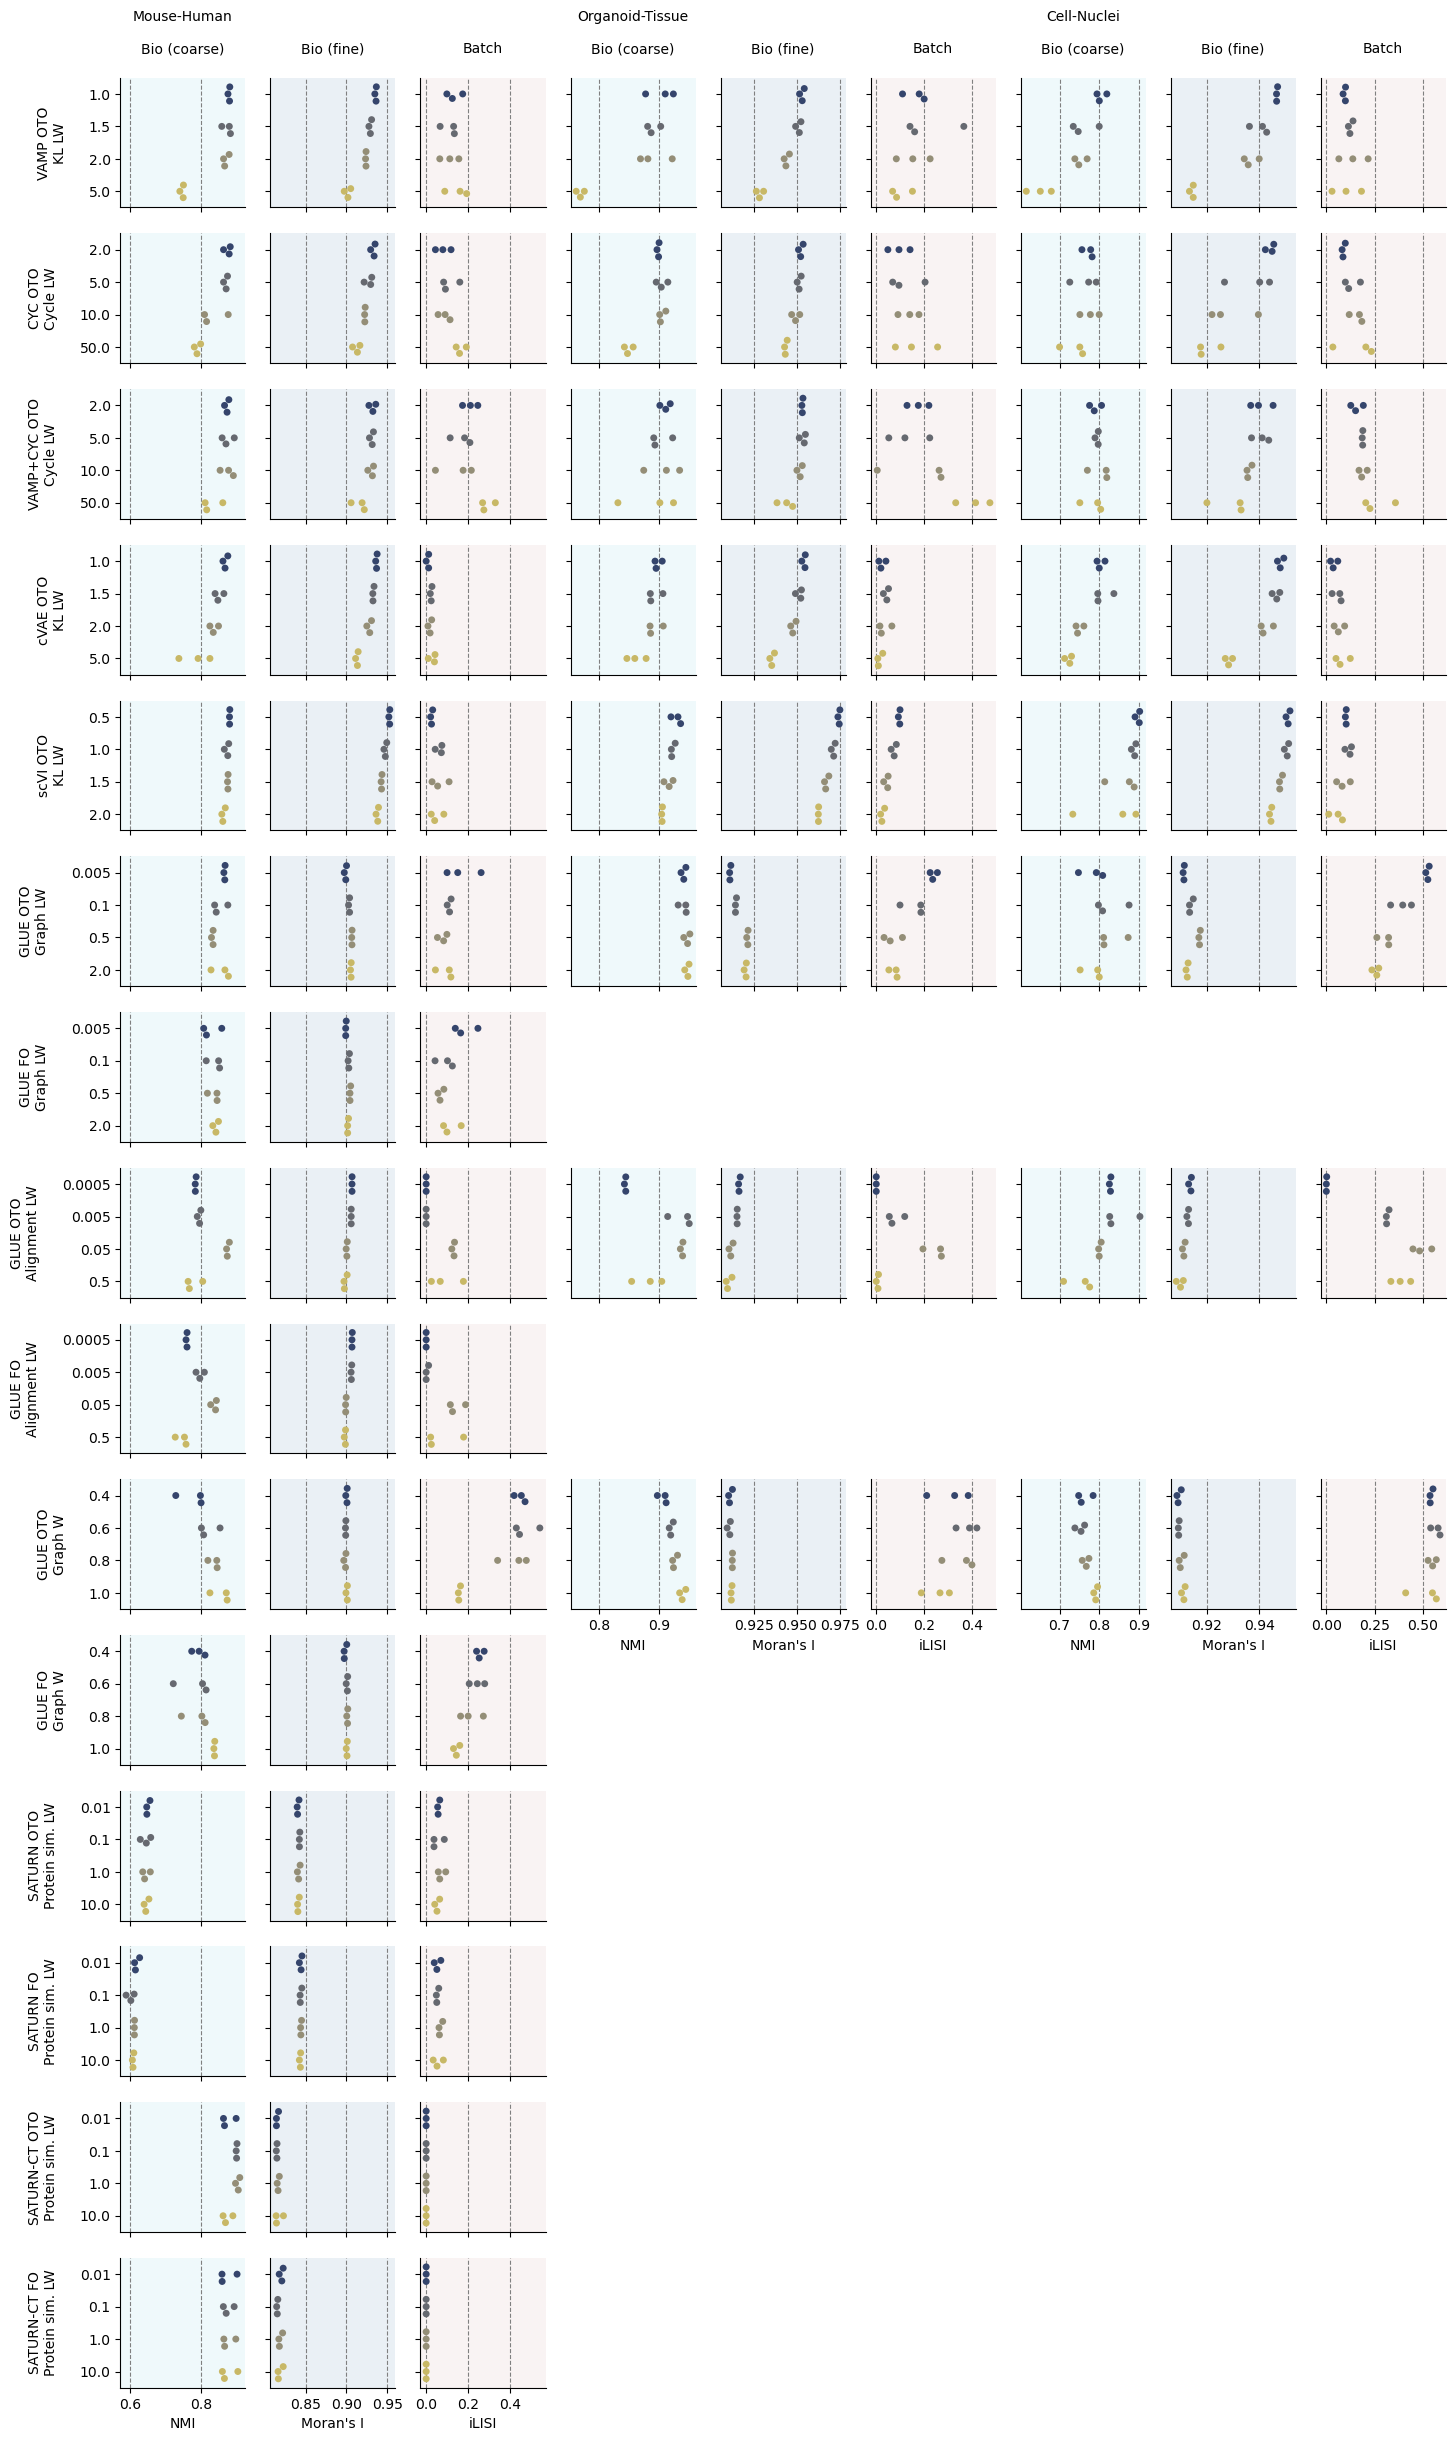

In [13]:
# Plot model+opt_param * metrics+dataset
params=ress.groupby(['model_parsed','param_parsed','genes_parsed'],observed=True,sort=True
            ).size().index.to_frame().reset_index(drop=True)
nrow=params.shape[0]
n_metrics=len(metric_map)
ncol=ress['dataset_parsed'].nunique()*n_metrics
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*1.9,nrow*2),sharex='col',sharey='row')
for icol_ds, (dataset_name,res_ds) in enumerate(ress.groupby('dataset_parsed')):
    
    # Max row for ds - some models not in all ds
    models_parsed_ds=set(res_ds.model_parsed)
    params_parsed_ds=set(res_ds.param_parsed)
    genes_parsed_ds=set(res_ds.genes_parsed)
    irow_max_ds=max([irow for irow,(model_parsed,param_parsed,genes_parsed) in params.iterrows() if 
     model_parsed in models_parsed_ds and 
     param_parsed in params_parsed_ds and
     genes_parsed in genes_parsed_ds])
    
    # Plot metric + opt param settings
    for icol_metric,(metric,metric_name) in enumerate(metric_map.items()):
        icol=icol_ds*n_metrics+icol_metric
        for irow,(_,param_data) in enumerate(params.iterrows()):
            ax=axs[irow,icol]
            res_sub=res_ds.query(
                f'model_parsed=="{param_data.model_parsed}" & '+\
                f'param_parsed=="{param_data.param_parsed}" & '+\
                f'genes_parsed=="{param_data.genes_parsed}"')
            if res_sub.shape[0]>0:
                res_sub=res_sub.copy()
                res_sub['param_opt_val_str']=\
                    res_sub['param_opt_val_str'].cat.remove_unused_categories()
                # Plot
                sb.swarmplot(x=metric,y='param_opt_val_str',data=res_sub,ax=ax, 
                            hue='param_opt_val_str',palette='cividis')
                
                # Make pretty
                ax.set(facecolor = metric_background_cmap[metric])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.grid(axis='x', linestyle='--', color='gray')
                ax.get_legend().remove()
                if irow!=irow_max_ds:
                    ax.set_xlabel('')
                else:
                    # Add xaxis
                    # Must turn label to visible as sb will set it off if sharex
                    # Must reset ticks as will be of due to sharex
                    ax.set_xlabel(metric_name,visible=True)
                    ax.xaxis.set_ticks_position('bottom')
                if irow==0:
                    title=''
                    if icol%3==0:
                        title=title+dataset_name+'\n\n'
                    ax.set_title(title+metric_meaning_map[metric]+'\n',fontsize=10)
                if icol==0:
                    ax.set_ylabel(
                        param_data.model_parsed+' '+param_data.genes_parsed+'\n'+\
                        param_data.param_parsed+'\n')
                else:
                    ax.set_ylabel('')
            else:
                ax.remove()
            

plt.subplots_adjust(wspace=0.2,hspace=0.2)
fig.set(facecolor = (0,0,0,0))

# Turn off tight layout as it messes up spacing if adding xlabels on intermediate plots
#fig.tight_layout()

# Save
plt.savefig(path_fig+'performance-score_all-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'performance-score_all-swarm.png',
            dpi=300,bbox_inches='tight')